In [1]:
# %%
# ============================================================================
# CONVOLUTIONAL LAYER COMPRESSION EXPERIMENT
# Complete Implementation of Algorithms 4 and 11 for Conv Layer Compression
# Based on Halko, Martinsson, and Tropp (2010)
# ============================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

PyTorch version: 2.5.1
Device: cuda


In [3]:
# ============================================================================
# RANDOMIZED SVD ALGORITHMS (FROM EXP_3.PY)
# ============================================================================

def algorithm_4_randomized_subspace_iteration(A, ell, q):
    """
    Algorithm 4: Randomized Subspace Iteration
    Input: Matrix A, integers ell (sample size), q (power iterations)
    Output: Orthonormal matrix Q approximating range of A
    """
    m, n = A.shape

    # Step 1: Draw n × ℓ Gaussian matrix Ω
    Omega = np.random.randn(n, ell)

    # Step 2: Form Y₀ = AΩ, compute QR: Y₀ = Q₀R₀
    Y_0 = A @ Omega
    Q_j, R_0 = np.linalg.qr(Y_0)

    # Step 3: Power iteration loop
    for j in range(1, q + 1):
        # Step 3a: Form Ỹⱼ = A*Qⱼ₋₁, compute QR: Ỹⱼ = Q̃ⱼR̃ⱼ
        Y_tilde_j = A.T @ Q_j
        Q_tilde_j, R_tilde_j = np.linalg.qr(Y_tilde_j)

        # Step 3b: Form Yⱼ = AQ̃ⱼ, compute QR: Yⱼ = QⱼRⱼ
        Y_j = A @ Q_tilde_j
        Q_j, R_j = np.linalg.qr(Y_j)

    # Step 4: Output Q = Qᵩ
    return Q_j

In [4]:
def algorithm_11_randomized_svd_power_iteration(A, k, q=2):
    """
    Algorithm 11: Randomized SVD with Power Iteration
    Input: Matrix A, target rank k, power iterations q
    Output: U, Σ, V^T such that A ≈ UΣV^T
    """
    m, n = A.shape

    # Step 1: Generate n × 2k Gaussian matrix Ω
    Omega = np.random.randn(n, 2 * k)

    # Step 2: Form Y = (AA*)^q AΩ using Algorithm 4
    Q = algorithm_4_randomized_subspace_iteration(A, 2 * k, q)

    # Step 3: Form B = Q*A
    B = Q.T @ A

    # Step 4: Compute SVD: B = ŨΣV*
    U_tilde, Sigma, Vt = np.linalg.svd(B, full_matrices=False)

    # Step 5: Set U = QŨ
    U = Q @ U_tilde

    # Step 6: Truncate to rank k
    rank = min(k, len(Sigma))
    U = U[:, :rank]
    Sigma = Sigma[:rank]
    Vt = Vt[:rank, :]

    return U, Sigma, Vt

In [5]:
def algorithm_2_basic_randomized_range_finder(A, ell):
    """
    Algorithm 2: Basic Randomized Range Finder
    Input: Matrix A, integer ell
    Output: Orthonormal matrix Q approximating range of A
    """
    m, n = A.shape

    # Step 1: Draw n × ℓ Gaussian random matrix Ω
    Omega = np.random.randn(n, ell)

    # Step 2: Form Y = AΩ
    Y = A @ Omega

    # Step 3: Compute QR factorization Y = QR to get orthonormal Q
    Q, R = np.linalg.qr(Y)

    return Q

In [6]:
def basic_randomized_svd(A, rank, oversampling=10):
    """
    Basic randomized SVD using Algorithm 2 + direct SVD
    """
    ell = min(rank + oversampling, min(A.shape))
    Q = algorithm_2_basic_randomized_range_finder(A, ell)
    B = Q.T @ A
    U_tilde, S, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde
    rank = min(rank, len(S))
    return U[:, :rank], S[:rank], Vt[:rank, :]

In [7]:
# ============================================================================
# CONVOLUTIONAL LAYER MATRIX UNFOLDING
# ============================================================================

def conv_to_matrix(weight, input_shape, stride=1, padding=0):
    """
    Convert convolutional layer to matrix form using im2col-like operation

    Args:
        weight: Conv layer weight tensor [out_channels, in_channels, kh, kw]
        input_shape: Input tensor shape [batch_size, in_channels, H, W]
        stride: Convolution stride
        padding: Convolution padding

    Returns:
        Matrix representation of convolution operation
    """
    out_channels, in_channels, kh, kw = weight.shape
    batch_size, _, H, W = input_shape

    # Calculate output dimensions
    H_out = (H + 2 * padding - kh) // stride + 1
    W_out = (W + 2 * padding - kw) // stride + 1

    # Reshape weight to matrix form
    # Shape: [out_channels, in_channels * kh * kw]
    weight_matrix = weight.view(out_channels, -1)

    return weight_matrix.cpu().numpy()

In [8]:
def matrix_to_conv(U, S, Vt, original_shape):
    """
    Convert compressed matrix back to convolutional layer format

    Args:
        U, S, Vt: SVD components
        original_shape: Original weight tensor shape

    Returns:
        Reconstructed weight tensor
    """
    # Reconstruct matrix
    reconstructed = U @ np.diag(S) @ Vt

    # Reshape back to conv layer format
    reconstructed_tensor = torch.from_numpy(reconstructed).float()
    reconstructed_tensor = reconstructed_tensor.view(original_shape)

    return reconstructed_tensor

In [9]:
# ============================================================================
# COMPRESSED CONVOLUTIONAL LAYER IMPLEMENTATION
# ============================================================================

class CompressedConv2D(nn.Module):
    """
    Compressed 2D Convolution using low-rank decomposition
    """
    def __init__(self, U, S, Vt, original_shape, stride=1, padding=0, bias=None):
        super(CompressedConv2D, self).__init__()

        out_channels, in_channels, kh, kw = original_shape
        rank = len(S)

        # Store original parameters
        self.original_shape = original_shape
        self.stride = stride
        self.padding = padding

        # Create two sequential conv layers for low-rank approximation
        # First conv: reduces channels from in_channels to rank
        self.conv1 = nn.Conv2d(in_channels, rank, kernel_size=(kh, kw),
                              stride=1, padding=padding, bias=False)

        # Second conv: expands from rank to out_channels
        self.conv2 = nn.Conv2d(rank, out_channels, kernel_size=1,
                              stride=stride, padding=0, bias=bias is not None)

        # Initialize weights using SVD decomposition
        self._initialize_from_svd(U, S, Vt)

        if bias is not None:
            self.conv2.bias.data = bias

    def _initialize_from_svd(self, U, S, Vt):
        """Initialize the two conv layers using SVD components"""
        rank = len(S)
        out_channels, in_channels, kh, kw = self.original_shape

        # Reshape Vt for first conv layer
        # Vt shape: [rank, in_channels * kh * kw] -> [rank, in_channels, kh, kw]
        V_reshaped = Vt.reshape(rank, in_channels, kh, kw)
        self.conv1.weight.data = torch.from_numpy(V_reshaped).float()

        # U and S for second conv layer
        # U shape: [out_channels, rank] -> [out_channels, rank, 1, 1]
        US = U @ np.diag(S)
        self.conv2.weight.data = torch.from_numpy(US).float().unsqueeze(-1).unsqueeze(-1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [10]:
# ============================================================================
# CNN ARCHITECTURE WITH TARGET CONV LAYER
# ============================================================================

class ConvTestCNN(nn.Module):
    """
    CNN architecture
    """
    def __init__(self, num_classes=10):
        super(ConvTestCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Target for compression
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # After two pooling operations: 32->16->8
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Conv1 + ReLU (32x32x32)
        x = F.relu(self.conv1(x))
        # Conv2 + ReLU (64x32x32)
        x = F.relu(self.conv2(x))
        # MaxPool (64x16x16)
        x = self.pool(x)
        # Conv3 + ReLU (128x16x16)
        x = F.relu(self.conv3(x))
        # MaxPool (128x8x8)
        x = self.pool(x)
        # Flatten (8192)
        x = x.view(x.size(0), -1)
        # FC1 + ReLU + Dropout (512)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # FC2 + ReLU + Dropout (256)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # FC3 (Output - 10)
        return self.fc3(x)

In [11]:
# ============================================================================
# DATA LOADING
# ============================================================================

def load_cifar10_data(batch_size=128):
    """Load CIFAR-10 dataset with appropriate transforms"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform_test)

    return DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2), \
           DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [12]:
# ============================================================================
# TRAINING AND EVALUATION FUNCTIONS
# ============================================================================

def train_model(model, trainloader, testloader, epochs=10, lr=0.001, print_freq=1):
    """Train the model"""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0.0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            loss_sum += loss.item()

        if epoch % print_freq == 0:
            train_acc = 100. * correct / total
            test_acc = evaluate_model(model, testloader)
            print(f"Epoch {epoch:2d}: Loss={loss_sum/len(trainloader):.4f}, "
                  f"Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")

    return model

def evaluate_model(model, dataloader):
    """Evaluate model accuracy"""
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    return 100. * correct / total

In [13]:
# ============================================================================
# CONVOLUTIONAL LAYER COMPRESSION FUNCTIONS
# ============================================================================

def compress_conv_layer(model, layer_name, rank, method='algorithm_11', q=2):
    """
    Compress convolutional layer using randomized SVD

    Args:
        model: PyTorch model
        layer_name: Name of layer to compress
        rank: Target rank for compression
        method: Compression method ('algorithm_11', 'algorithm_4', 'basic')
        q: Power iterations for algorithm_11 and algorithm_4

    Returns:
        compression_ratio: Compression ratio achieved
        elapsed_time: Time taken for compression
    """
    # Get the layer
    layer = getattr(model, layer_name)

    # Extract weight and bias
    weight = layer.weight.data
    bias = layer.bias.data if layer.bias is not None else None

    # Store original parameters
    original_shape = weight.shape
    stride = layer.stride[0] if isinstance(layer.stride, tuple) else layer.stride
    padding = layer.padding[0] if isinstance(layer.padding, tuple) else layer.padding

    # Convert to matrix form (assuming square input for simplicity)
    input_shape = (1, weight.shape[1], 32, 32)  # CIFAR-10 input size
    W_matrix = conv_to_matrix(weight, input_shape, stride, padding)

    # Ensure rank is valid
    rank = min(rank, min(W_matrix.shape) - 1)

    print(f"Original {layer_name} shape: {original_shape}")
    print(f"Matrix shape: {W_matrix.shape}")
    print(f"Compressing to rank: {rank}")

    start_time = time.time()

    # Apply compression method
    if method == 'algorithm_11':
        U, S, Vt = algorithm_11_randomized_svd_power_iteration(W_matrix, rank, q)
    elif method == 'algorithm_4':
        Q = algorithm_4_randomized_subspace_iteration(W_matrix, rank + 10, q)
        B = Q.T @ W_matrix
        U_tilde, S, Vt = np.linalg.svd(B, full_matrices=False)
        U = Q @ U_tilde
        rank = min(rank, len(S))
        U, S, Vt = U[:, :rank], S[:rank], Vt[:rank, :]
    elif method == 'basic':
        U, S, Vt = basic_randomized_svd(W_matrix, rank)
    else:
        raise ValueError(f"Unknown method: {method}")

    elapsed_time = time.time() - start_time

    # Replace the layer with compressed version
    compressed_layer = CompressedConv2D(U, S, Vt, original_shape, stride, padding, bias)
    setattr(model, layer_name, compressed_layer)

    # Calculate compression statistics
    original_params = weight.numel()
    compressed_params = U.size + S.size + Vt.size
    compression_ratio = original_params / compressed_params

    print(f"Compression: {compression_ratio:.2f}x, Time: {elapsed_time:.3f}s")

    return compression_ratio, elapsed_time

In [14]:
# ============================================================================
# FINE-TUNING FUNCTION
# ============================================================================

def fine_tune_model(model, trainloader, testloader, epochs=5, lr=0.0001):
    """
    Fine-tune the compressed model to recover accuracy
    """
    print("Fine-tuning compressed model...")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0.0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            loss_sum += loss.item()

        train_acc = 100. * correct / total
        test_acc = evaluate_model(model, testloader)
        best_acc = max(best_acc, test_acc)

        print(f"Fine-tune Epoch {epoch:2d}: Loss={loss_sum/len(trainloader):.4f}, "
              f"Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")

    return best_acc

In [15]:
# ============================================================================
# ANALYSIS FUNCTIONS
# ============================================================================

def analyze_conv_layer_spectrum(model, layer_name, plot=True):
    """
    Analyze the singular value spectrum of convolutional layers
    """
    layer = getattr(model, layer_name)
    weight = layer.weight.data

    # Convert to matrix form
    input_shape = (1, weight.shape[1], 32, 32)
    stride = layer.stride[0] if isinstance(layer.stride, tuple) else layer.stride
    padding = layer.padding[0] if isinstance(layer.padding, tuple) else layer.padding

    W_matrix = conv_to_matrix(weight, input_shape, stride, padding)

    # Compute full SVD
    U, S, Vt = np.linalg.svd(W_matrix, full_matrices=False)

    if plot:
        plt.figure(figsize=(15, 5))

        # Plot singular values
        plt.subplot(1, 3, 1)
        plt.semilogy(S, 'b-', linewidth=2)
        plt.xlabel('Index')
        plt.ylabel('Singular Value')
        plt.title(f'{layer_name} Singular Values')
        plt.grid(True)

        # Plot normalized singular values
        plt.subplot(1, 3, 2)
        normalized_S = S / S[0]
        plt.semilogy(normalized_S, 'r-', linewidth=2)
        plt.xlabel('Index')
        plt.ylabel('Normalized Singular Value')
        plt.title(f'{layer_name} Normalized Singular Values')
        plt.grid(True)

        # Plot cumulative energy
        plt.subplot(1, 3, 3)
        energy = np.cumsum(S**2) / np.sum(S**2)
        plt.plot(energy, 'g-', linewidth=2)
        plt.xlabel('Index')
        plt.ylabel('Cumulative Energy')
        plt.title(f'{layer_name} Cumulative Energy')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Calculate statistics
    decay_rate = np.mean(np.diff(np.log(S + 1e-10)))

    print(f"\n{layer_name} Analysis:")
    print(f"Original shape: {weight.shape}")
    print(f"Matrix shape: {W_matrix.shape}")
    print(f"Rank: {len(S)}")
    print(f"Condition number: {S[0]/S[-1]:.2e}")
    print(f"Average log decay rate: {decay_rate:.4f}")
    print(f"90% energy at rank: {np.argmax(np.cumsum(S**2) / np.sum(S**2) > 0.9)}")

    return S

In [16]:
# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def plot_compression_results(results, original_accuracy):
    """
    Create separate plots for compression results
    """
    
    # Plot 1: Accuracy vs Rank (Before Fine-tuning)
    plt.figure(figsize=(10, 6))
    for method in results:
        plt.plot(results[method]['ranks'], results[method]['accuracies_before'],
                marker='o', linewidth=2, markersize=8, label=method.replace('_', ' ').title())
    plt.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2, label='Original')
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Accuracy vs Rank (Before Fine-tuning)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot 2: Accuracy vs Rank (After Fine-tuning)
    plt.figure(figsize=(10, 6))
    for method in results:
        plt.plot(results[method]['ranks'], results[method]['accuracies_after'],
                marker='s', linewidth=2, markersize=8, label=method.replace('_', ' ').title())
    plt.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2, label='Original')
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Accuracy vs Rank (After Fine-tuning)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot 3: Accuracy Drop vs Compression Ratio
    plt.figure(figsize=(10, 6))
    for method in results:
        drops_after = [original_accuracy - acc for acc in results[method]['accuracies_after']]
        plt.plot(results[method]['compression_ratios'], drops_after,
                marker='s', linewidth=2, markersize=8, label=method.replace('_', ' ').title())
    plt.xlabel('Compression Ratio', fontsize=12)
    plt.ylabel('Accuracy Drop (%)', fontsize=12)
    plt.title('Accuracy Drop vs Compression Ratio (After Fine-tuning)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot 4: Decomposition Time vs Rank
    plt.figure(figsize=(10, 6))
    for method in results:
        plt.plot(results[method]['ranks'], results[method]['decomp_times'],
                marker='^', linewidth=2, markersize=8, label=method.replace('_', ' ').title())
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Decomposition Time (s)', fontsize=12)
    plt.title('Decomposition Time vs Rank', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot 5: Memory vs Accuracy Trade-off
    plt.figure(figsize=(10, 6))
    for method in results:
        plt.plot(results[method]['compression_ratios'], results[method]['accuracies_after'],
                marker='h', linewidth=2, markersize=8, label=method.replace('_', ' ').title())
    plt.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2, label='Original')
    plt.xlabel('Compression Ratio', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Memory vs Accuracy Trade-off', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot 6: Fine-tuning Recovery Rate
    plt.figure(figsize=(10, 6))
    for method in results:
        recovery_rates = []
        for i in range(len(results[method]['ranks'])):
            before = results[method]['accuracies_before'][i]
            after = results[method]['accuracies_after'][i]
            recovery = (after - before) / (original_accuracy - before) * 100 if before < original_accuracy else 0
            recovery_rates.append(recovery)
        plt.plot(results[method]['ranks'], recovery_rates,
                marker='d', linewidth=2, markersize=8, label=method.replace('_', ' ').title())
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Recovery Rate (%)', fontsize=12)
    plt.title('Fine-tuning Recovery Rate', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

In [17]:
# ============================================================================
# COMPREHENSIVE EXPERIMENT
# ============================================================================

def comprehensive_conv_compression_experiment():
    """
    Comprehensive experiment for convolutional layer compression
    """
    print("="*80)
    print("COMPREHENSIVE CONVOLUTIONAL LAYER COMPRESSION EXPERIMENT")
    print("="*80)

    # Load data
    print("\nLoading CIFAR-10 dataset...")
    trainloader, testloader = load_cifar10_data()

    # Train original model
    print("\nTraining original model...")
    original_model = ConvTestCNN()
    train_model(original_model, trainloader, testloader, epochs=15, lr=0.001)
    original_accuracy = evaluate_model(original_model, testloader)
    print(f"\nOriginal model accuracy: {original_accuracy:.2f}%")

    # Analyze conv2 layer spectrum
    print("\nAnalyzing conv2 layer spectrum...")
    analyze_conv_layer_spectrum(original_model, 'conv2')

    # Test different compression settings
    ranks = [8, 16, 24, 32]
    methods = ['algorithm_11', 'algorithm_4', 'basic']
    results = {}

    for method in methods:
        print(f"\n" + "="*60)
        print(f"TESTING {method.replace('_', ' ').upper()}")
        print("="*60)

        results[method] = {
            'ranks': [],
            'accuracies_before': [],
            'accuracies_after': [],
            'compression_ratios': [],
            'decomp_times': [],
            'finetune_times': []
        }

        for rank in ranks:
            print(f"\n--- Testing rank {rank} ---")

            # Create copy of original model
            model_copy = ConvTestCNN()
            model_copy.load_state_dict(original_model.state_dict())

            # Compress conv2 layer
            try:
                compression_ratio, decomp_time = compress_conv_layer(
                    model_copy, 'conv2', rank, method, q=2)

                # Evaluate before fine-tuning
                model_copy.to(device)
                acc_before = evaluate_model(model_copy, testloader)
                print(f"Accuracy before fine-tuning: {acc_before:.2f}%")

                # Fine-tune the model
                start_finetune = time.time()
                acc_after = fine_tune_model(model_copy, trainloader, testloader, epochs=5, lr=0.0001)
                finetune_time = time.time() - start_finetune

                print(f"Final accuracy after fine-tuning: {acc_after:.2f}%")
                print(f"Improvement: {acc_after - acc_before:.2f}%")

                # Store results
                results[method]['ranks'].append(rank)
                results[method]['accuracies_before'].append(acc_before)
                results[method]['accuracies_after'].append(acc_after)
                results[method]['compression_ratios'].append(compression_ratio)
                results[method]['decomp_times'].append(decomp_time)
                results[method]['finetune_times'].append(finetune_time)

            except Exception as e:
                print(f"Error with rank {rank}: {e}")
                continue

    # Plot comprehensive results
    print("\n" + "="*60)
    print("PLOTTING RESULTS")
    print("="*60)
    plot_compression_results(results, original_accuracy)

    # Print detailed summary
    print("\n" + "="*80)
    print("DETAILED RESULTS SUMMARY")
    print("="*80)

    for method in methods:
        print(f"\n{method.replace('_', ' ').upper()}:")
        print("-" * 40)
        for i, rank in enumerate(results[method]['ranks']):
            before = results[method]['accuracies_before'][i]
            after = results[method]['accuracies_after'][i]
            ratio = results[method]['compression_ratios'][i]
            decomp_t = results[method]['decomp_times'][i]
            finetune_t = results[method]['finetune_times'][i]

            print(f"Rank {rank:2d}: "
                  f"Before={before:5.2f}% | After={after:5.2f}% | "
                  f"Compression={ratio:4.1f}x | "
                  f"Decomp={decomp_t:5.3f}s | Finetune={finetune_t:5.1f}s")

    # Best configurations analysis
    print("\n" + "="*60)
    print("BEST CONFIGURATIONS ANALYSIS")
    print("="*60)

    best_configs = []
    for method in methods:
        if results[method]['accuracies_after']:
            best_idx = np.argmax(results[method]['accuracies_after'])
            best_config = {
                'method': method,
                'rank': results[method]['ranks'][best_idx],
                'accuracy': results[method]['accuracies_after'][best_idx],
                'compression': results[method]['compression_ratios'][best_idx],
                'total_time': results[method]['decomp_times'][best_idx] + results[method]['finetune_times'][best_idx]
            }
            best_configs.append(best_config)

    print("\nBest accuracy for each method:")
    for config in sorted(best_configs, key=lambda x: x['accuracy'], reverse=True):
        print(f"{config['method'].replace('_', ' ').title():15s}: "
              f"{config['accuracy']:5.2f}% (rank {config['rank']:2d}, "
              f"{config['compression']:4.1f}x compression, "
              f"{config['total_time']:5.1f}s total)")

    return results, original_accuracy

In [18]:
# ============================================================================
# ADDITIONAL ANALYSIS FUNCTIONS
# ============================================================================

def compare_compression_methods_detailed():
    """
    Detailed comparison of compression methods with various metrics
    """
    print("\n" + "="*60)
    print("DETAILED COMPRESSION METHODS COMPARISON")
    print("="*60)

    # Create and train a model for analysis
    trainloader, testloader = load_cifar10_data()
    model = ConvTestCNN()
    train_model(model, trainloader, testloader, epochs=10)

    # Analyze different layers
    layers_to_analyze = ['conv1', 'conv2', 'conv3']

    for layer_name in layers_to_analyze:
        print(f"\n--- Analyzing {layer_name} ---")
        spectrum = analyze_conv_layer_spectrum(model, layer_name, plot=True)

        # Find optimal rank based on energy threshold
        layer = getattr(model, layer_name)
        weight = layer.weight.data
        input_shape = (1, weight.shape[1], 32, 32)
        W_matrix = conv_to_matrix(weight, input_shape)

        U, S, Vt = np.linalg.svd(W_matrix, full_matrices=False)

        # Calculate ranks for different energy thresholds
        energy_cumsum = np.cumsum(S**2) / np.sum(S**2)

        print(f"Recommended ranks for {layer_name}:")
        for threshold in [0.8, 0.9, 0.95, 0.99]:
            rank = np.argmax(energy_cumsum > threshold) + 1
            compression = W_matrix.size / (U[:, :rank].size + S[:rank].size + Vt[:rank, :].size)
            print(f"  {threshold*100:2.0f}% energy: rank {rank:2d} (compression: {compression:.1f}x)")

def memory_analysis():
    """
    Analyze memory usage of different compression methods
    """
    print("\n" + "="*60)
    print("MEMORY USAGE ANALYSIS")
    print("="*60)

    # Create model and analyze memory
    model = ConvTestCNN()

    # Calculate original memory usage
    total_params = sum(p.numel() for p in model.parameters())
    conv_params = sum(p.numel() for name, p in model.named_parameters() if 'conv' in name)

    print(f"Original model:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Conv parameters: {conv_params:,}")
    print(f"  Memory (float32): {total_params * 4 / 1024 / 1024:.2f} MB")

    # Analyze conv2 layer specifically
    conv2_params = model.conv2.weight.numel()
    print(f"\nConv2 layer analysis:")
    print(f"  Original parameters: {conv2_params:,}")

    # Test different compression ratios
    ranks = [8, 16, 24, 32]
    for rank in ranks:
        # Calculate compressed size
        weight_shape = model.conv2.weight.shape
        out_ch, in_ch, kh, kw = weight_shape

        # For CompressedConv2D: two conv layers
        params_conv1 = rank * in_ch * kh * kw  # First conv layer
        params_conv2 = out_ch * rank * 1 * 1   # Second conv layer
        compressed_params = params_conv1 + params_conv2

        compression_ratio = conv2_params / compressed_params
        memory_saving = (conv2_params - compressed_params) * 4 / 1024  # KB

        print(f"  Rank {rank:2d}: {compressed_params:,} params, "
              f"{compression_ratio:.1f}x compression, "
              f"{memory_saving:.1f} KB saved")

In [19]:
# ============================================================================
# ROBUSTNESS TESTING
# ============================================================================

def robustness_test():
    """
    Test robustness of compression methods across different scenarios
    """
    print("\n" + "="*60)
    print("ROBUSTNESS TESTING")
    print("="*60)

    trainloader, testloader = load_cifar10_data()

    # Test with different power iterations
    print("\nTesting different power iterations (q):")
    model = ConvTestCNN()
    train_model(model, trainloader, testloader, epochs=10)
    original_acc = evaluate_model(model, testloader)

    q_values = [1, 2, 3, 4]
    rank = 16

    for q in q_values:
        model_copy = ConvTestCNN()
        model_copy.load_state_dict(model.state_dict())

        # Compress with different q values
        compression_ratio, decomp_time = compress_conv_layer(
            model_copy, 'conv2', rank, 'algorithm_11', q=q)

        model_copy.to(device)
        acc_before = evaluate_model(model_copy, testloader)
        acc_after = fine_tune_model(model_copy, trainloader, testloader, epochs=3)

        print(f"q={q}: Decomp={decomp_time:.3f}s, "
              f"Before={acc_before:.2f}%, After={acc_after:.2f}%")

    # Test with different oversampling ratios
    print("\nTesting different oversampling ratios:")
    oversampling_ratios = [0, 5, 10, 15]

    for ratio in oversampling_ratios:
        model_copy = ConvTestCNN()
        model_copy.load_state_dict(model.state_dict())

        # Modify basic_randomized_svd to test oversampling
        layer = model_copy.conv2
        weight = layer.weight.data
        W_matrix = conv_to_matrix(weight, (1, 32, 32, 32))

        start_time = time.time()
        U, S, Vt = basic_randomized_svd(W_matrix, rank, oversampling=ratio)
        decomp_time = time.time() - start_time

        # Create compressed layer
        compressed_layer = CompressedConv2D(
            U, S, Vt, weight.shape, 1, 1, layer.bias.data)
        model_copy.conv2 = compressed_layer

        model_copy.to(device)
        acc_before = evaluate_model(model_copy, testloader)
        acc_after = fine_tune_model(model_copy, trainloader, testloader, epochs=3)

        print(f"Oversampling {ratio:2d}: Decomp={decomp_time:.3f}s, "
              f"Before={acc_before:.2f}%, After={acc_after:.2f}%")

CONVOLUTIONAL LAYER COMPRESSION WITH RANDOMIZED SVD
Implementation of Algorithms 4 & 11 from Halko, Martinsson, and Tropp (2010)
COMPREHENSIVE CONVOLUTIONAL LAYER COMPRESSION EXPERIMENT

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified

Training original model...
Epoch  0: Loss=1.6872, Train Acc=36.84%, Test Acc=55.27%
Epoch  1: Loss=1.2656, Train Acc=54.45%, Test Acc=64.60%
Epoch  2: Loss=1.0957, Train Acc=61.23%, Test Acc=67.67%
Epoch  3: Loss=0.9965, Train Acc=65.25%, Test Acc=71.29%
Epoch  4: Loss=0.9343, Train Acc=67.52%, Test Acc=72.35%
Epoch  5: Loss=0.8889, Train Acc=69.26%, Test Acc=73.28%
Epoch  6: Loss=0.8493, Train Acc=70.61%, Test Acc=75.38%
Epoch  7: Loss=0.8231, Train Acc=71.73%, Test Acc=75.92%
Epoch  8: Loss=0.7916, Train Acc=72.66%, Test Acc=77.47%
Epoch  9: Loss=0.7795, Train Acc=73.14%, Test Acc=77.31%
Epoch 10: Loss=0.7574, Train Acc=73.91%, Test Acc=77.73%
Epoch 11: Loss=0.7420, Train Acc=74.61%, Test Acc=78.7

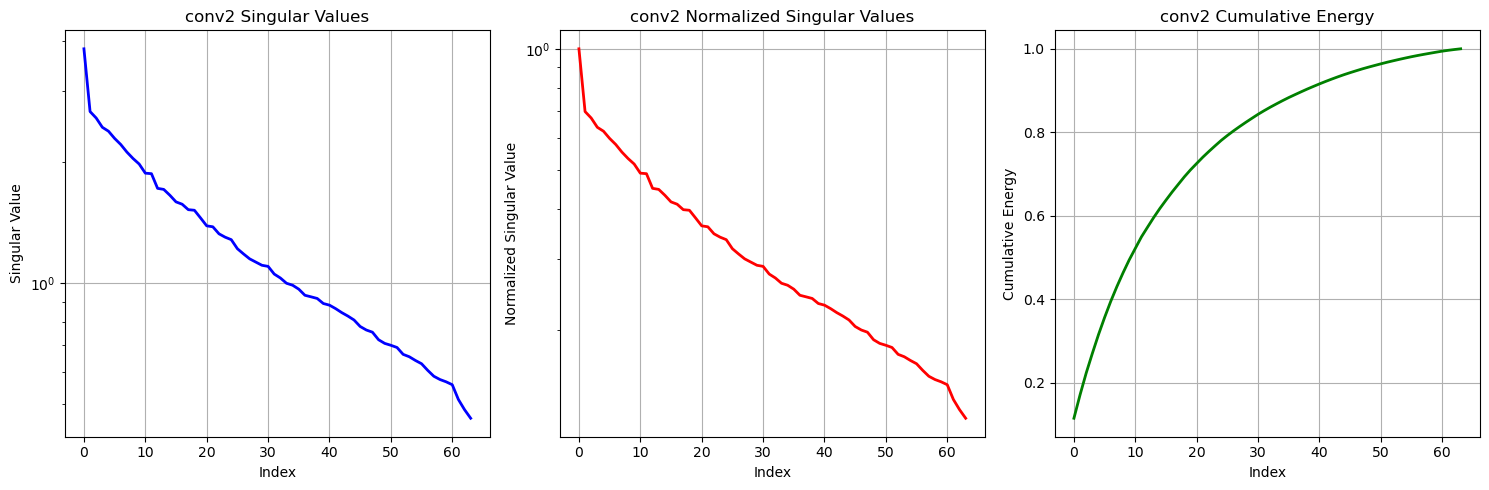


conv2 Analysis:
Original shape: torch.Size([64, 32, 3, 3])
Matrix shape: (64, 288)
Rank: 64
Condition number: 8.27e+00
Average log decay rate: -0.0335
90% energy at rank: 38

TESTING ALGORITHM 11

--- Testing rank 8 ---
Original conv2 shape: torch.Size([64, 32, 3, 3])
Matrix shape: (64, 288)
Compressing to rank: 8
Compression: 6.53x, Time: 0.001s
Accuracy before fine-tuning: 41.85%
Fine-tuning compressed model...
Fine-tune Epoch  0: Loss=1.1323, Train Acc=61.14%, Test Acc=72.82%
Fine-tune Epoch  1: Loss=0.8818, Train Acc=69.37%, Test Acc=75.09%
Fine-tune Epoch  2: Loss=0.8283, Train Acc=71.30%, Test Acc=76.25%
Fine-tune Epoch  3: Loss=0.7973, Train Acc=72.35%, Test Acc=76.64%
Fine-tune Epoch  4: Loss=0.7690, Train Acc=73.53%, Test Acc=77.43%
Final accuracy after fine-tuning: 77.43%
Improvement: 35.58%

--- Testing rank 16 ---
Original conv2 shape: torch.Size([64, 32, 3, 3])
Matrix shape: (64, 288)
Compressing to rank: 16
Compression: 3.26x, Time: 0.003s
Accuracy before fine-tuning: 60

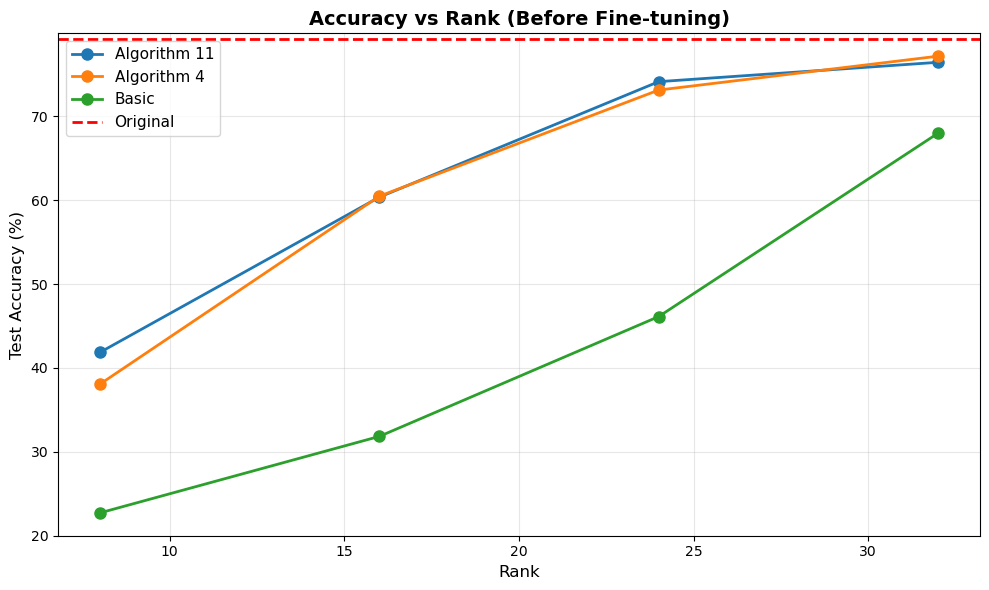

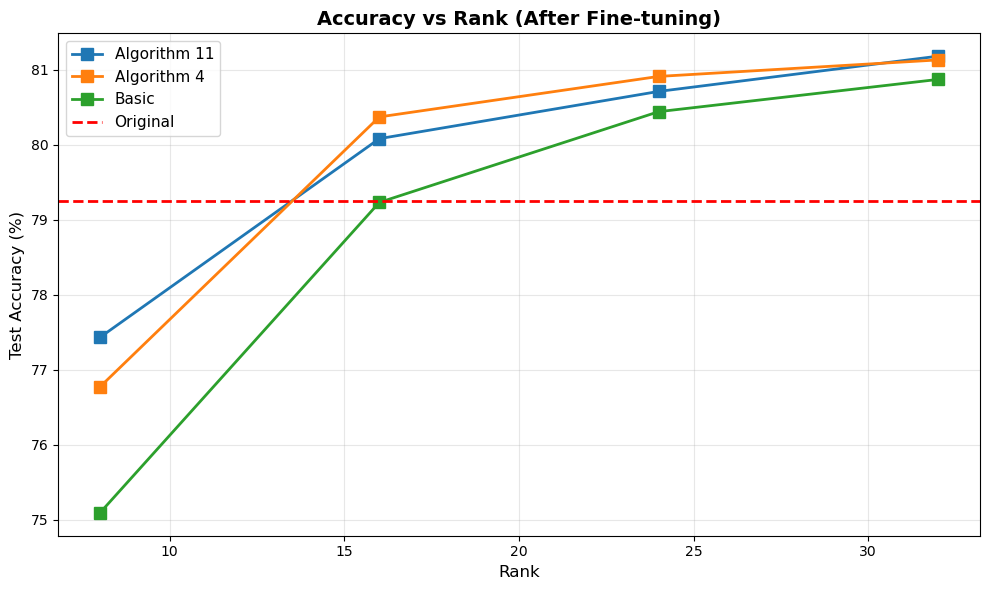

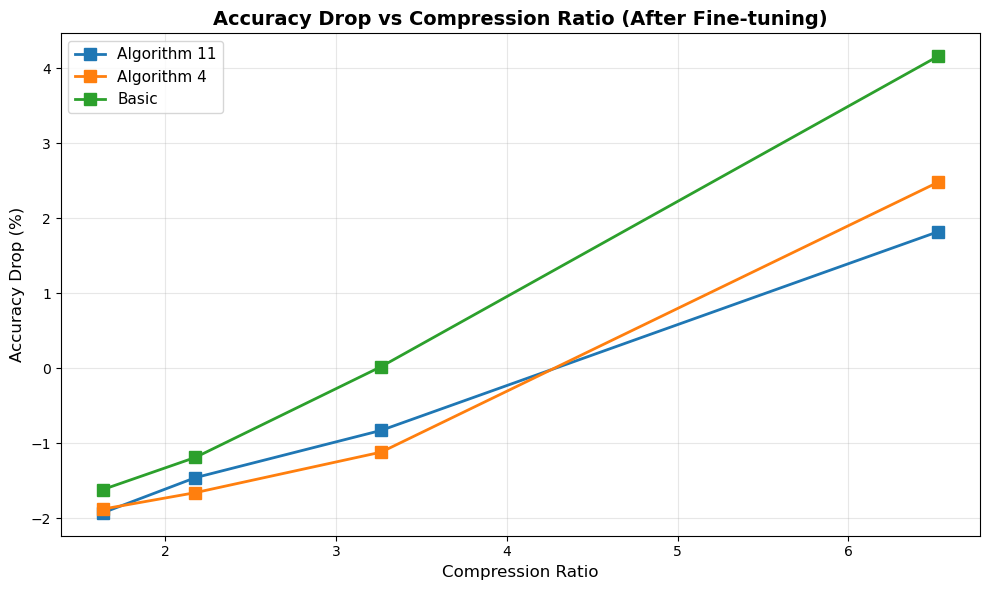

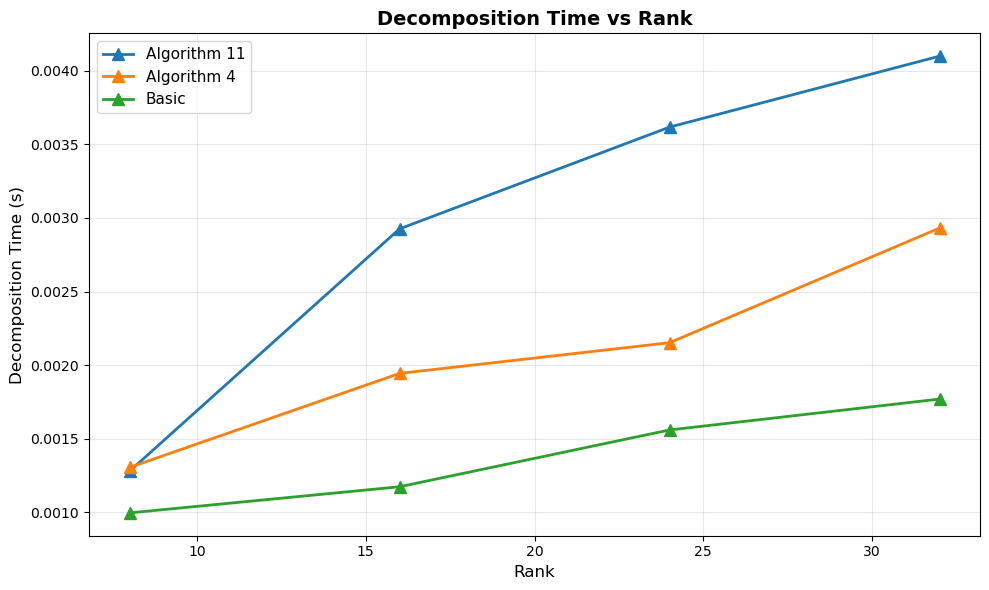

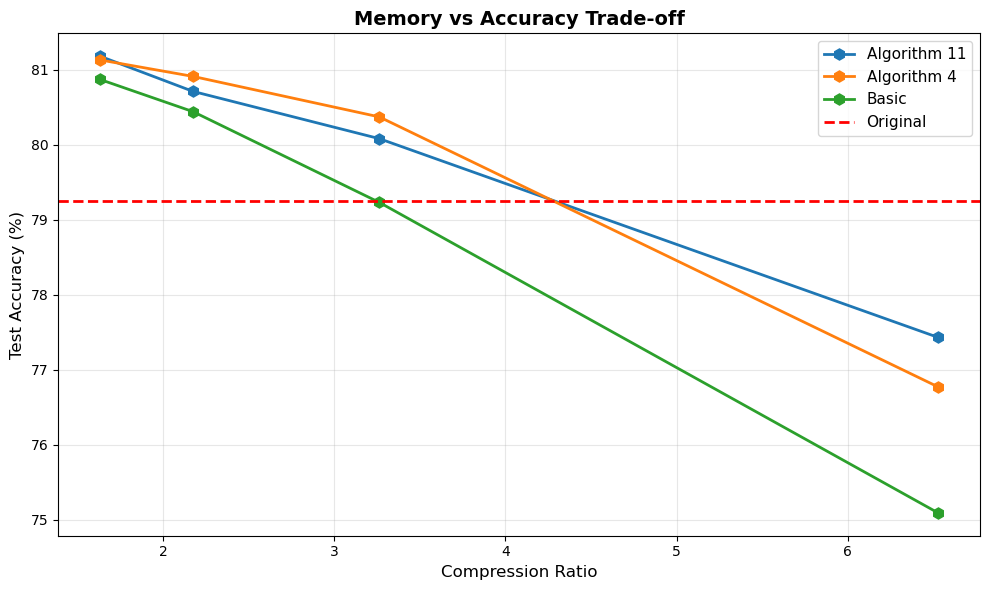

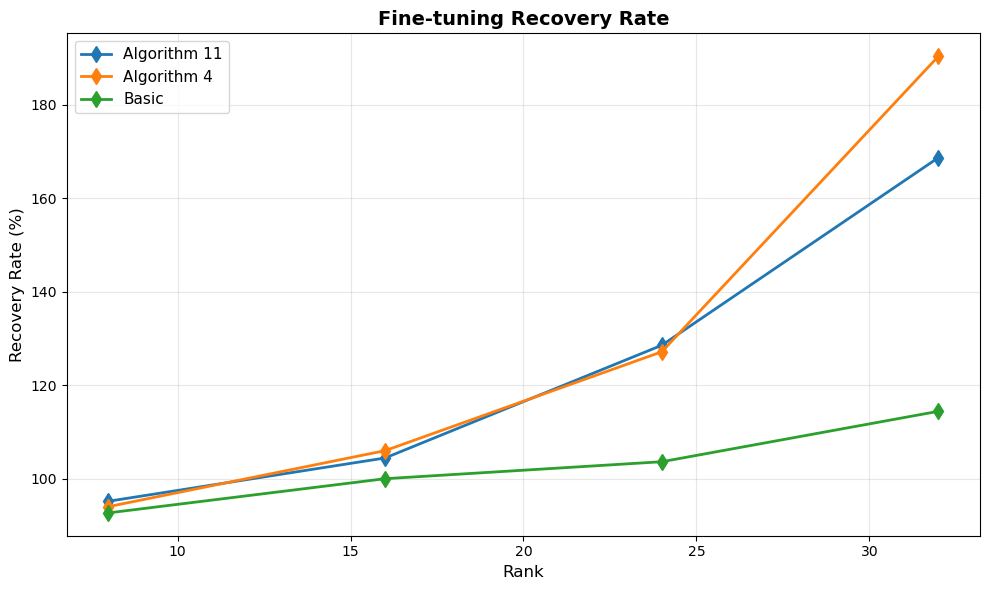


DETAILED RESULTS SUMMARY

ALGORITHM 11:
----------------------------------------
Rank  8: Before=41.85% | After=77.43% | Compression= 6.5x | Decomp=0.001s | Finetune= 44.6s
Rank 16: Before=60.36% | After=80.08% | Compression= 3.3x | Decomp=0.003s | Finetune= 43.7s
Rank 24: Before=74.13% | After=80.71% | Compression= 2.2x | Decomp=0.004s | Finetune= 45.9s
Rank 32: Before=76.44% | After=81.18% | Compression= 1.6x | Decomp=0.004s | Finetune= 47.1s

ALGORITHM 4:
----------------------------------------
Rank  8: Before=38.06% | After=76.77% | Compression= 6.5x | Decomp=0.001s | Finetune= 44.6s
Rank 16: Before=60.47% | After=80.37% | Compression= 3.3x | Decomp=0.002s | Finetune= 43.7s
Rank 24: Before=73.13% | After=80.91% | Compression= 2.2x | Decomp=0.002s | Finetune= 45.9s
Rank 32: Before=77.17% | After=81.13% | Compression= 1.6x | Decomp=0.003s | Finetune= 36.5s

BASIC:
----------------------------------------
Rank  8: Before=22.71% | After=75.09% | Compression= 6.5x | Decomp=0.001s | Fi

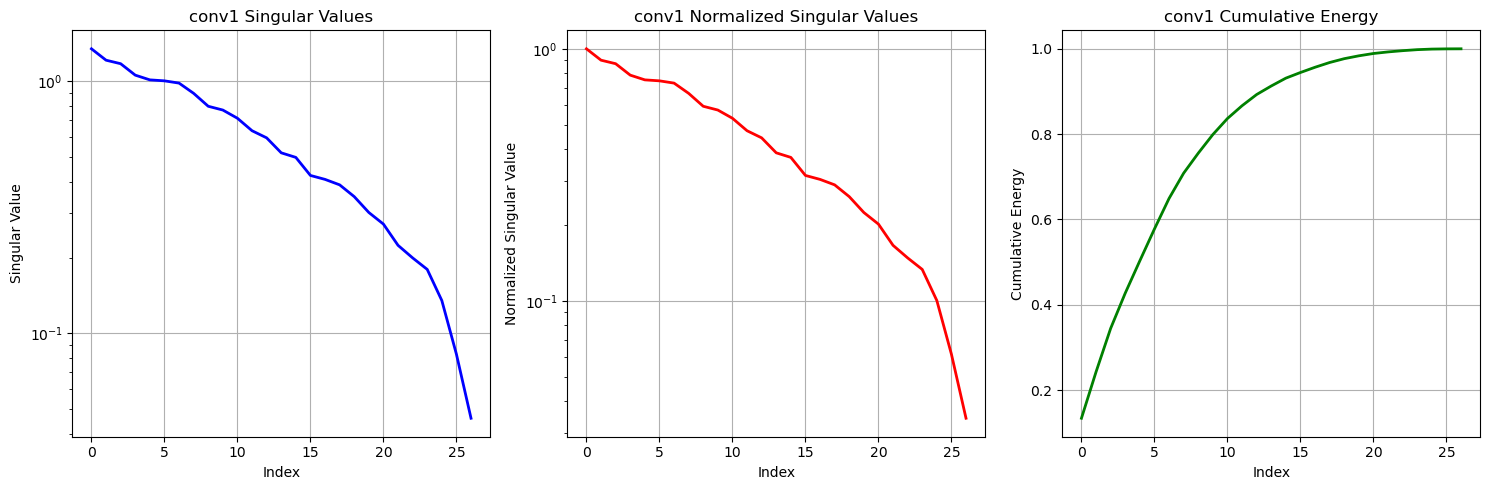


conv1 Analysis:
Original shape: torch.Size([32, 3, 3, 3])
Matrix shape: (32, 27)
Rank: 27
Condition number: 2.93e+01
Average log decay rate: -0.1298
90% energy at rank: 13
Recommended ranks for conv1:
  80% energy: rank 11 (compression: 1.3x)
  90% energy: rank 14 (compression: 1.0x)
  95% energy: rank 17 (compression: 0.8x)
  99% energy: rank 22 (compression: 0.7x)

--- Analyzing conv2 ---


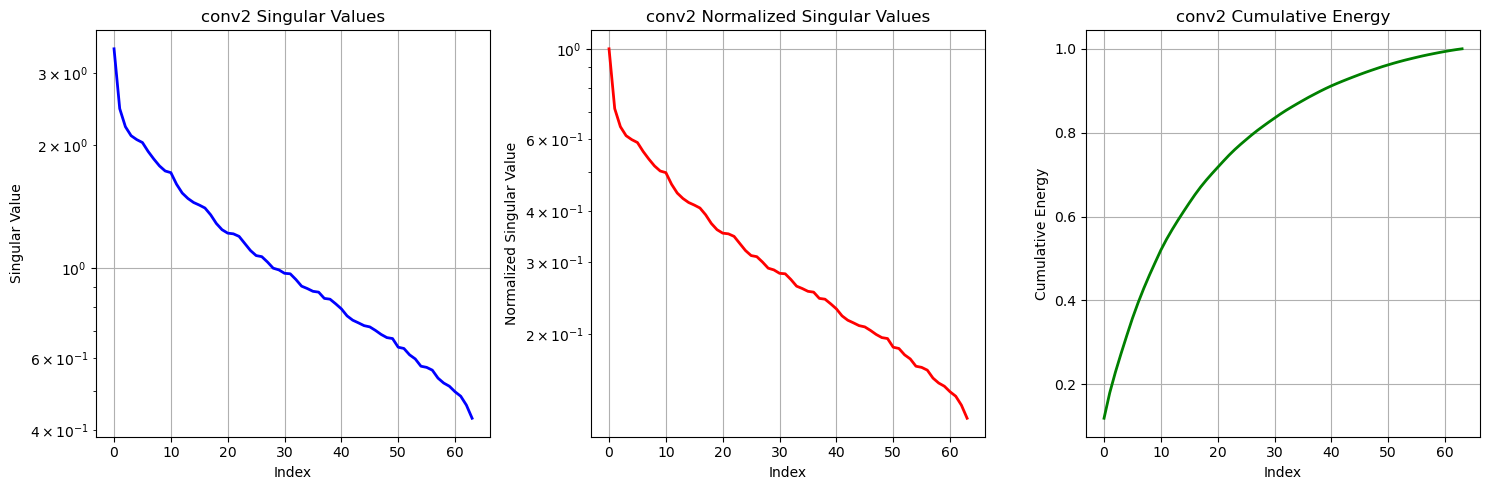


conv2 Analysis:
Original shape: torch.Size([64, 32, 3, 3])
Matrix shape: (64, 288)
Rank: 64
Condition number: 8.03e+00
Average log decay rate: -0.0331
90% energy at rank: 39
Recommended ranks for conv2:
  80% energy: rank 28 (compression: 1.9x)
  90% energy: rank 40 (compression: 1.3x)
  95% energy: rank 49 (compression: 1.1x)
  99% energy: rank 60 (compression: 0.9x)

--- Analyzing conv3 ---


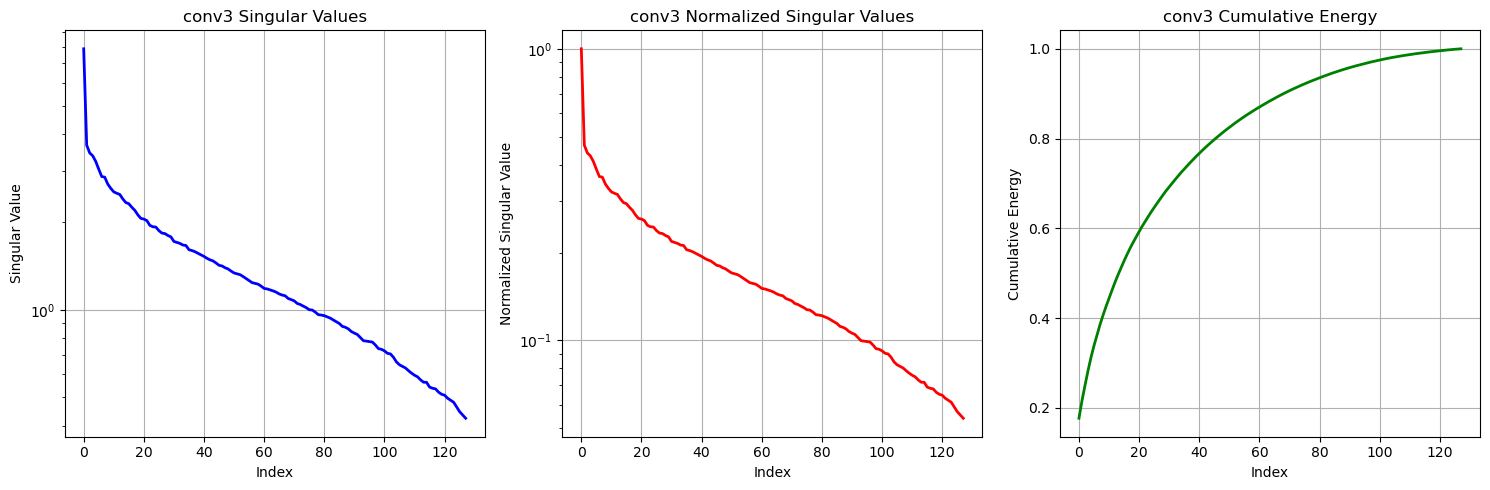


conv3 Analysis:
Original shape: torch.Size([128, 64, 3, 3])
Matrix shape: (128, 576)
Rank: 128
Condition number: 1.85e+01
Average log decay rate: -0.0230
90% energy at rank: 68
Recommended ranks for conv3:
  80% energy: rank 47 (compression: 2.2x)
  90% energy: rank 69 (compression: 1.5x)
  95% energy: rank 88 (compression: 1.2x)
  99% energy: rank 114 (compression: 0.9x)

MEMORY USAGE ANALYSIS
Original model:
  Total parameters: 4,421,962
  Conv parameters: 93,248
  Memory (float32): 16.87 MB

Conv2 layer analysis:
  Original parameters: 18,432
  Rank  8: 2,816 params, 6.5x compression, 61.0 KB saved
  Rank 16: 5,632 params, 3.3x compression, 50.0 KB saved
  Rank 24: 8,448 params, 2.2x compression, 39.0 KB saved
  Rank 32: 11,264 params, 1.6x compression, 28.0 KB saved

ROBUSTNESS TESTING
Files already downloaded and verified
Files already downloaded and verified

Testing different power iterations (q):
Epoch  0: Loss=1.6614, Train Acc=38.41%, Test Acc=56.81%
Epoch  1: Loss=1.2185, T

In [20]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("="*80)
    print("CONVOLUTIONAL LAYER COMPRESSION WITH RANDOMIZED SVD")
    print("Implementation of Algorithms 4 & 11 from Halko, Martinsson, and Tropp (2010)")
    print("="*80)

    # Run comprehensive experiment
    results, original_accuracy = comprehensive_conv_compression_experiment()

    # Run additional analyses
    compare_compression_methods_detailed()
    memory_analysis()
    robustness_test()

    print("\n" + "="*80)
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("="*80)